In [1]:
#Ya Khode Khoda

In [2]:
import pandas as pd 
import numpy as np
from IPython.display import clear_output
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
import matplotlib.cm as cm
import matplotlib as matplotlib

from fastdtw import fastdtw
from copy import deepcopy
def color_map_color(value, cmap_name='coolwarm', vmin=0, vmax=10):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color
cl=['r','g','b','c','m','y','k']
color=dict()
for i,el in enumerate(cl):
    color.update({i:el})

#extract the labels for clutering precision its for after clustering
def time_convertor(x):
    s,h,m=0,0,0
    s=round(x%60,2)
    m=int(x/60)
    h=int(m/60)
    m=m%60
    time=str(h)+':'+str(m)+':'+str(s)
    return pd.to_datetime('1970-01-01 '+time)


# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})

In [3]:
#read data
with open("normalized_data.txt", "rb") as fp:
        dfRaw = pickle.load(fp)
        
def get_label(number,df):
    label_event_lenght=dict()
    df=pd.read_csv(f'{number}\\groundTruth.csv')
    df['length']=df.en-df.st
    for event , dft in df.groupby('evento'):
        if (event in label_event_lenght):
            label_event_lenght.update({event : label_event_lenght[event]+list(dft.length) })
        else:
            label_event_lenght.update({event : list(dft.length)})

    df['st_time']=df.apply(lambda x:time_convertor(x.st) ,axis=1 )
    df['en_time']=df.apply(lambda x:time_convertor(x.en) ,axis=1 )
    df=df.drop('st',1).drop('en',1).drop('length',1)
    evented_label=list()
    for i in range(len(df)):
        evented_label.append((df.iloc[i][0],df.iloc[i][1],df.iloc[i][2]))
    eve=pd.DataFrame(evented_label)
    eve[3]=[f'evented_label_{number}' for x in evented_label]
    return eve
Ev=[get_label(dfRaw[x][0],dfRaw[x][1]) for x in range(len(dfRaw))]
evented_label_All=pd.concat(Ev).reset_index().drop('index',1)

window={226:['curva_direita_agressiva','curva_esquerda_agressiva','aceleracao_agressiva'],
        126:['troca_faixa_direita_agressiva','troca_faixa_esquerda_agressiva'],
        186:['freada_agressiva']
       }


In [3]:
#optimaze the forward step for the labeled dataset
#param for optimization


t1=time.time()
def TempEvent_genarator_new(Lambda,df,L,i):
    M=int((L)*Lambda)
    temp_event=list()
    pointer=0
    stop=False
    #go on timeserise for event extraction
    while stop!=True:
        clear_output(wait=True)
        pointer=pointer + M
        l_min=pointer-int(L/2)
        l_max=pointer+int(L/2)
        if l_max<0:
            l_max=L/2
        if (l_min<0):
            l_min=0
        if (l_max>len(df)):
            l_max=len(df)
            stop=True
        print('extraction ',l_max/len(df),' % of ',i,' is complete')
        temp_event.append(df[l_min:l_max])
    return temp_event

def has_overlap(A_start, A_end, B_start, B_end):
    latest_start = max(A_start, B_start)
    earliest_end = min(A_end, B_end)
    return latest_start <= earliest_end

def export_labels(tempevent,evented_label):
    EvL=pd.DataFrame(evented_label)
    Labels={
          226:[],
          126:[],
          186:[],
           }
    for i,wind in enumerate(Labels):
        label=['NAG' for x in tempevent[i][1]]
        for name in tempevent[i][0]:
            el=[(x[1],x[2]) for x in EvL.iloc if x[0]==name]
            for j,te in enumerate(tempevent[i][1]):
                    sta =te.index[0]
                    ena =te.index[-1]
                    for stb,enb in el:
                        if has_overlap(sta,ena,stb,enb):
                            label[j]=name
        Labels[wind]=label
    return Labels




LAMBDA=list()

for Lambda in np.linspace(0.1,1,10):
    temp_event_test=list()
    for l,DF in enumerate([x[1] for x in dfRaw]):
        te=list()
        for i,lw in enumerate(window):
            te.append((window[lw],TempEvent_genarator_new(Lambda,DF,lw,i+1)))
        temp_event_test.append(te)

    #make it dataframe
    Data_test={
          226:[],
          126:[],
          186:[],
           }
    for i,temp in enumerate(temp_event_test):
        TempEv={
                  226:[ x for x in temp_event_test[i][0][1] ],
                  126:[ x for x in temp_event_test[i][1][1] ],
                  186:[ x for x in temp_event_test[i][2][1] ],
                   }
        Label=export_labels(temp_event_test[i],Ev[i])
        #merge together
        for wind in Data_test:
            for j in range(len(TempEv[wind])):
                Data_test[wind].append((Label[wind][j],TempEv[wind][j]))

    #calculate distance
    k,n=0,0
    num_event=dict(evented_label_All.groupby(0).size())
    for lenght in window:
        for name in window[lenght]:
            k=k+len(Data_test[lenght])*num_event[name]

    Data_DS_test={
          226:[],
          126:[],
          186:[],
           }

    for wind in Data_test:
        for label,event in Data_test[wind]:
             #---------for each Data-distance from events----------
            Y=list()
            for from_event,dfe in evented_label_All.groupby(0):
                if from_event in window[wind]:
                    X=list()
                    #____for each event_distance from each label_____
                    for el in dfe.iloc:
                        clear_output(wait=True)
                        n=n+1
                        print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
                        if   el[3]=='evented_label_16':
                            X.append(fastdtw(event,dfRaw[0][1][el[1]:el[2]])[0])
                        elif el[3]=='evented_label_17':
                            X.append(fastdtw(event,dfRaw[1][1][el[1]:el[2]])[0])
                        elif el[3]=='evented_label_20':
                            X.append(fastdtw(event,dfRaw[2][1][el[1]:el[2]])[0])
                        elif el[3]=='evented_label_21':
                            X.append(fastdtw(event,dfRaw[3][1][el[1]:el[2]])[0])
                    #_________________________________________________
                    Y.append((from_event,X))
            Data_DS_test[wind].append((label,Y))
            #------------------------------------------------------

    #prepare dataset for labeling
    TrainData_test=dict()
    for win in Data_DS_test:
        x=Data_DS_test[win]
        dumy_list=list()
        for events in x:
            dumy_dict=dict()
            dumy_dict.update({'label':events[0]})
            for name , event in events[1]:
                for tag,number in enumerate(event):
                    dumy_dict.update({name+str(tag):number})
            dumy_list.append(dumy_dict)
        TrainData_test.update({win:pd.DataFrame(dumy_list)})
    LAMBDA.append((Lambda,deepcopy(TrainData_test)))

with open("TrainData_test_Optimize_Forward_step.txt", "wb") as fp:
    pickle.dump(LAMBDA, fp)
t2=time.time()
print(round((t2-t1)/60) ,'min has time left')

disstance calculatoin  100.0  %  is complete
1039 min has time left


In [4]:
from copy import deepcopy
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support

Models=dict()
with open("Model_02v02.txt", "rb") as fp:
     Models['V-0.2']=pickle.load(fp)
with open("Model_02v04.txt", "rb") as fp:
     Models['V-0.4']=pickle.load(fp)
with open("Model_0200.txt", "rb") as fp:
     Models['V-1.0']=pickle.load(fp)
with open("Model_02v12.txt", "rb") as fp:
     Models['V-1.2']=pickle.load(fp)
with open("Model_02v15.txt", "rb") as fp:
     Models['V-1.5']=pickle.load(fp)

with open("TrainData_test_Optimize_Forward_step.txt", "rb") as fp:
    LAMBDA = pickle.load(fp)

with open("Runtime.txt", "rb") as fp:
     Runtime=pickle.load(fp)

def extract_item(List,item):
    return [x[item] for x in List]


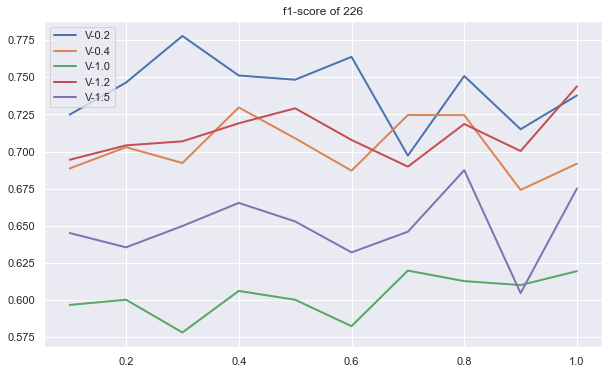

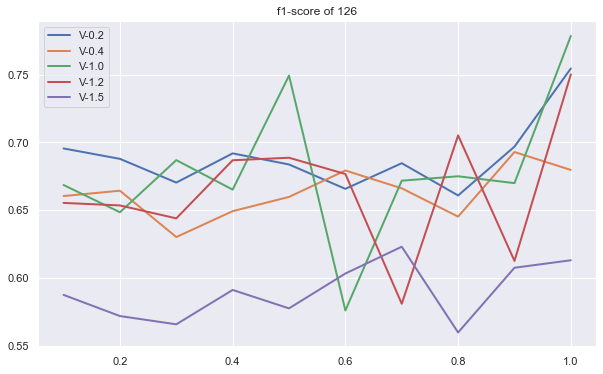

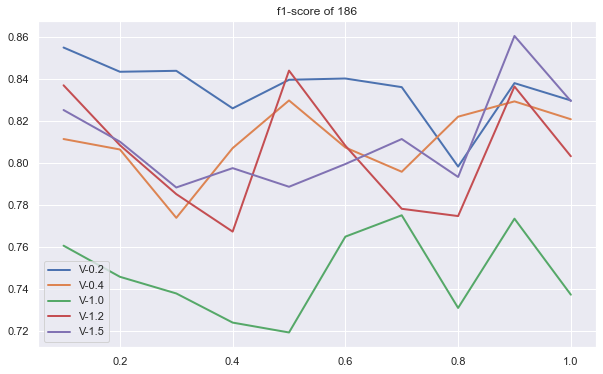

In [5]:
for wid in window:
    Macro_f1_score=list()
    for model_name in Models:
        temp_list=list()
        for Lambda in range(len(LAMBDA)):
            estimator=Models[model_name][wid][0]
            TrainData_test=LAMBDA[Lambda][1]
            data=TrainData_test[wid].drop('label',1)
            label=TrainData_test[wid].label
            temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
        Macro_f1_score.append((model_name,temp_list))

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6, forward=True)
    for model_name,chart in Macro_f1_score:
        ax.plot(np.linspace(0.1,1,10),chart, linestyle='-', linewidth=2,label=model_name)
    ax.legend();
    ax.set_title(f'f1-score of {wid}')
    plt.show() 


In [126]:
def get_detail(Lambda,wid,line):
    Lambda=int(Lambda*10)-1
    estimator,depth_of_tree=Models[line][wid]
    print('===================================================================')
    print(f"  lambda: {LAMBDA[Lambda][0]:.2f} || window: {wid} || line: {line} || depth of tree: {depth_of_tree}" )
    print(f"time to calculatoin : {LAMBDA[Lambda][0]*wid*0.02:.2f} || calculation time : {depth_of_tree*Runtime[wid]}" )
    
    print('-------------------------------------------------------------------')
    TrainData_test=LAMBDA[Lambda][1]
    data=TrainData_test[wid].drop('label',1)
    label=TrainData_test[wid].label
    print(classification_report(label, estimator.predict(data)))
    print('===================================================================')


In [127]:
wid=226
line='A0075'
Lambda=0.5
get_detail(Lambda,wid,line)

wid=226
line='A0075'
Lambda=1
get_detail(Lambda,wid,line)


wid=226
line='A0075'
Lambda=0.7
get_detail(Lambda,wid,line)


  lambda: 0.50 || window: 226 || line: A0075 || depth of tree: 14
time to calculatoin : 2.26 || calculation time : 0.8051955909572477
-------------------------------------------------------------------
                          precision    recall  f1-score   support

                     NAG       0.97      0.99      0.98      1261
    aceleracao_agressiva       0.71      0.49      0.58        45
 curva_direita_agressiva       0.91      0.74      0.82        39
curva_esquerda_agressiva       0.86      0.84      0.85        38

                accuracy                           0.96      1383
               macro avg       0.86      0.77      0.81      1383
            weighted avg       0.96      0.96      0.96      1383

  lambda: 1.00 || window: 226 || line: A0075 || depth of tree: 14
time to calculatoin : 4.52 || calculation time : 0.8051955909572477
-------------------------------------------------------------------
                          precision    recall  f1-score   support

 # best of 226 
 
 lambda: 1.00 || window: 226 || line: A0075 || depth of tree: 14 
 
 is the best because it has enough time to calculate the 14 level tree ! but we have to calculate it percisely!

In [128]:
wid=126
line='A0200'
Lambda=1
get_detail(Lambda,wid,line)


wid=126
line='A0125'
Lambda=1
get_detail(Lambda,wid,line)

wid=126
line='A0175'
Lambda=0.8
get_detail(Lambda,wid,line)



  lambda: 1.00 || window: 126 || line: A0200 || depth of tree: 8
time to calculatoin : 2.52 || calculation time : 0.2722117752078287
-------------------------------------------------------------------
                                precision    recall  f1-score   support

                           NAG       1.00      1.00      1.00      1227
 troca_faixa_direita_agressiva       0.62      0.62      0.62         8
troca_faixa_esquerda_agressiva       0.71      0.71      0.71         7

                      accuracy                           0.99      1242
                     macro avg       0.78      0.78      0.78      1242
                  weighted avg       0.99      0.99      0.99      1242

  lambda: 1.00 || window: 126 || line: A0125 || depth of tree: 8
time to calculatoin : 2.52 || calculation time : 0.2722117752078287
-------------------------------------------------------------------
                                precision    recall  f1-score   support

                  

 # best of 126 
 
 lambda: 1.00 || window: 126 || line: A0125 || depth of tree: 8
 
 is the best because it has: less tree depth , better percision , also lambda 1 to complete the calculation !

In [129]:
wid=186
line='A0050'
Lambda=0.6
get_detail(Lambda,wid,line)

wid=186
line='A0150'
Lambda=0.7
get_detail(Lambda,wid,line)


  lambda: 0.60 || window: 186 || line: A0050 || depth of tree: 10
time to calculatoin : 2.23 || calculation time : 0.44878773364272395
-------------------------------------------------------------------
                  precision    recall  f1-score   support

             NAG       0.99      0.99      0.99      1377
freada_agressiva       0.76      0.78      0.77        32

        accuracy                           0.99      1409
       macro avg       0.88      0.89      0.88      1409
    weighted avg       0.99      0.99      0.99      1409

  lambda: 0.70 || window: 186 || line: A0150 || depth of tree: 11
time to calculatoin : 2.60 || calculation time : 0.4936665070069963
-------------------------------------------------------------------
                  precision    recall  f1-score   support

             NAG       0.99      1.00      0.99      1176
freada_agressiva       0.89      0.61      0.72        28

        accuracy                           0.99      1204
       mac

 # best of 126 
 
 both of them are acceptable and can choose for application

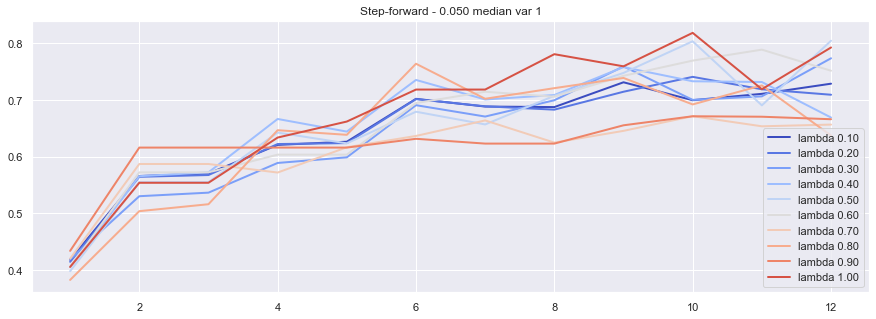

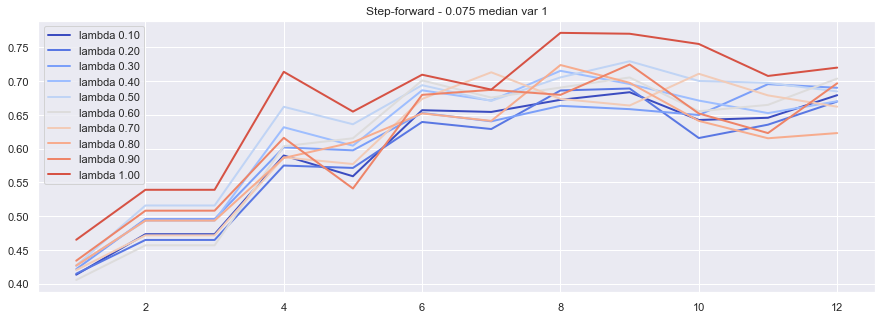

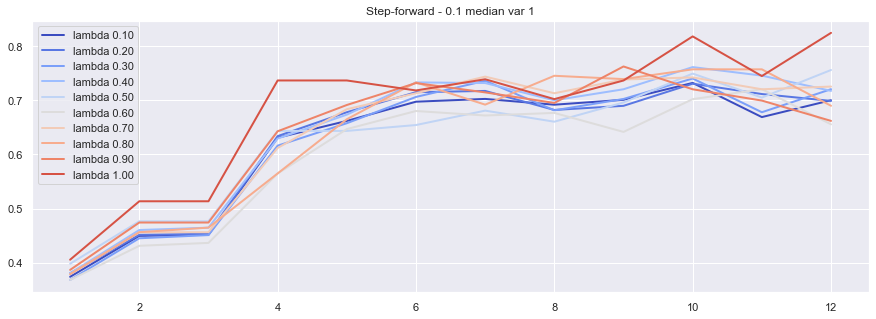

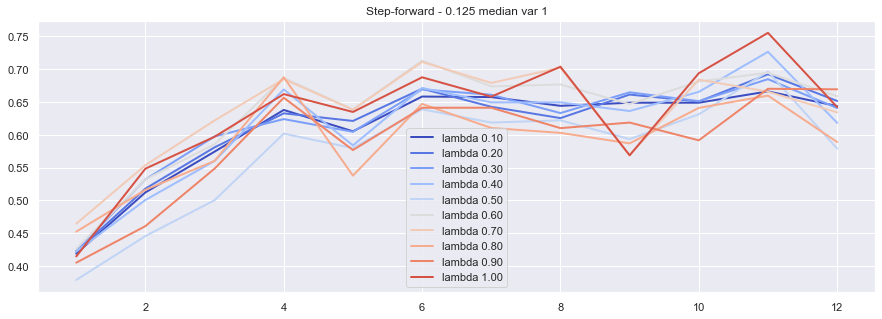

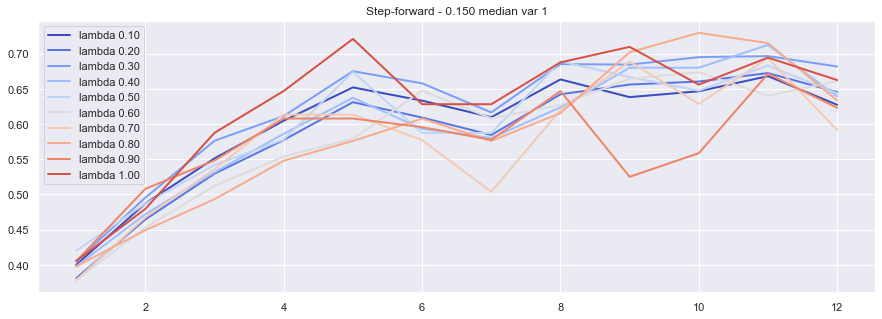

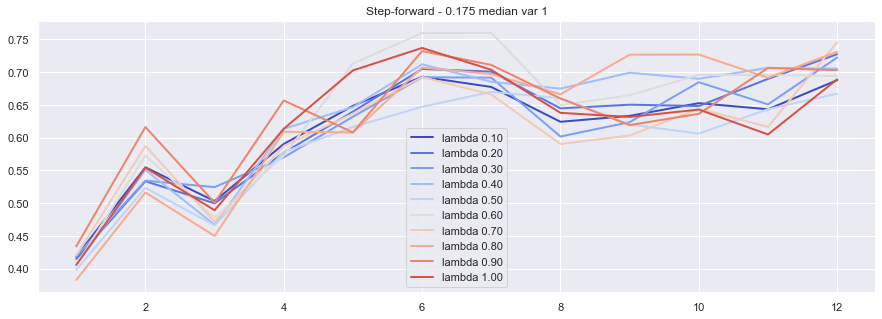

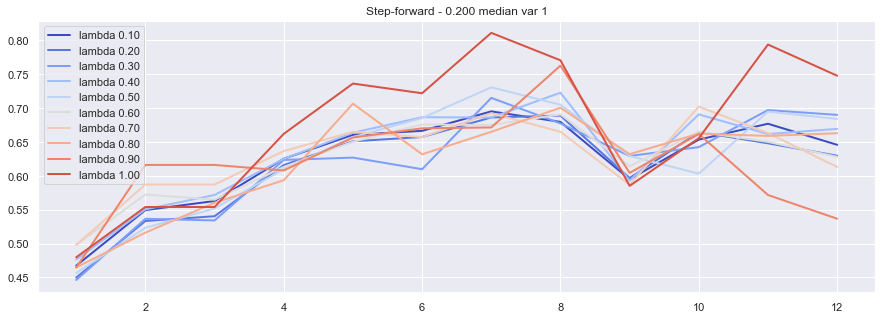

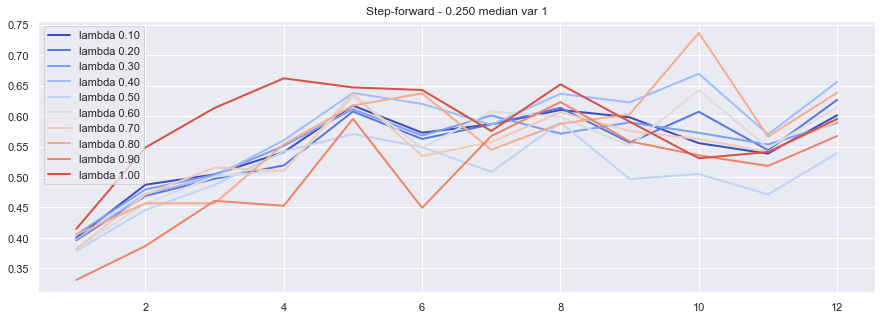

In [30]:
#check the optimality of step forward windowing
wid=126
X=range(1,13)
#0.05
Result=deepcopy(Result050_v1)
Micro_f1_score=list()
for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))
fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 0.050 median var 1')
plt.show() 
#0.075
Result=deepcopy(Result075_v1)
Micro_f1_score=list()
for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))
fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 0.075 median var 1')
plt.show() 
#0.1
Result=deepcopy(Result100_v1)
Micro_f1_score=list()
for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))
fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 0.1 median var 1')
plt.show() 

#0.125
Result=deepcopy(Result125_v1)
Micro_f1_score=list()
for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))
fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 0.125 median var 1')
plt.show() 

#0.150
Result=deepcopy(Result150_v1)
Micro_f1_score=list()
for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))
fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 0.150 median var 1')
plt.show() 

#0.175
Result=deepcopy(Result175_v1)
Micro_f1_score=list()
for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))
fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 0.175 median var 1')
plt.show() 
#0.200
Result=deepcopy(Result200_v1)
Micro_f1_score=list()
for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))
fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 0.200 median var 1')
plt.show() 

#0.250
Result=deepcopy(Result250_v1)
Micro_f1_score=list()
for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))
fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 0.250 median var 1')
plt.show() 

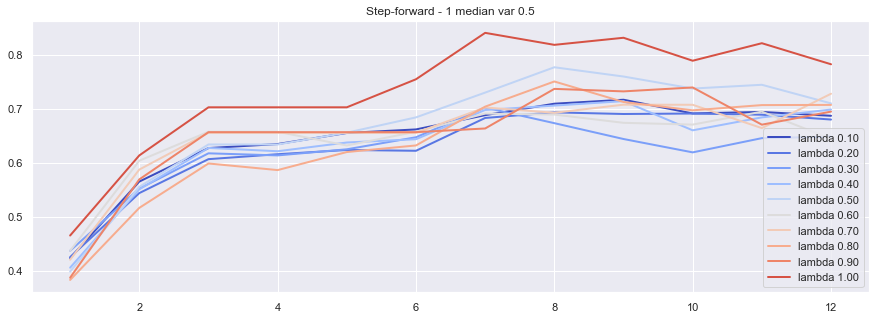

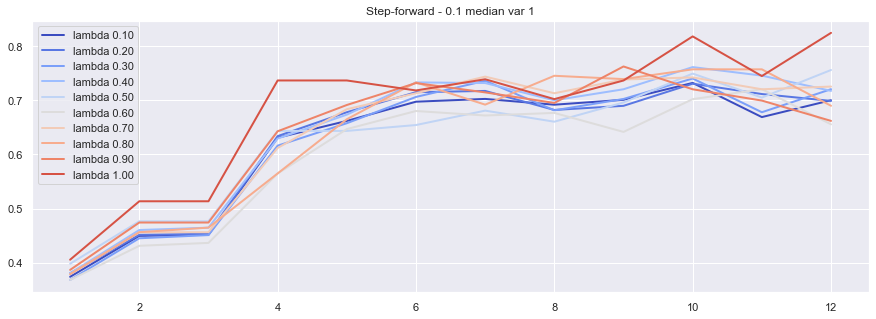

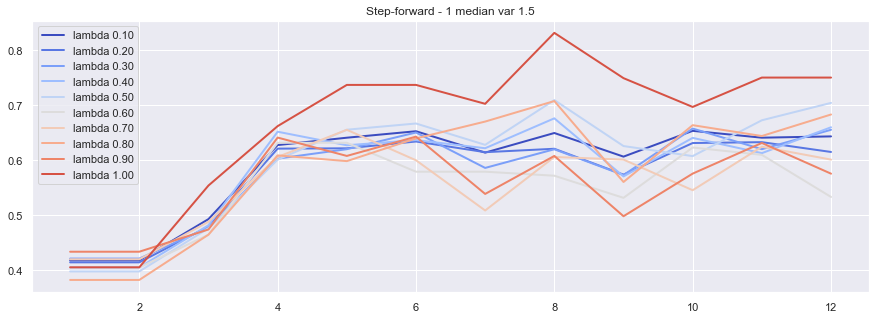

In [20]:
#check the importance of variance
wid=126

Result=deepcopy(Result01_v05)
Micro_f1_score=list()

X=range(1,13)

for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))

fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
ax.set_title('Step-forward - 1 median var 0.5')
plt.show() 
#------------
Result=deepcopy(Result01_v1)

Micro_f1_score=list()

X=range(1,13)

for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))

fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.set_title('Step-forward - 0.1 median var 1')
ax.legend();
plt.show() 

#-------------------------
Result=deepcopy(Result01_v15)

Micro_f1_score=list()

X=range(1,13)

for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))

fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.set_title('Step-forward - 1 median var 1.5')
ax.legend();
plt.show() 

In [41]:
wid=126
Max_depth=9
Lambda=1

Result=deepcopy(Result100_v1)

TrainData_test=LAMBDA[Lambda][1]
print(f"step_forward parameter is : {LAMBDA[Lambda][0]} ")
data=TrainData_test[wid].drop('label',1)
label=TrainData_test[wid].label

estimator=Result[wid][Max_depth-1][1]

print(classification_report(label, estimator.predict(data)))


step_forward parameter is : 0.2 
                                precision    recall  f1-score   support

                           NAG       0.99      1.00      1.00      6167
 troca_faixa_direita_agressiva       0.91      0.43      0.58        49
troca_faixa_esquerda_agressiva       0.70      0.38      0.49        37

                      accuracy                           0.99      6253
                     macro avg       0.87      0.60      0.69      6253
                  weighted avg       0.99      0.99      0.99      6253



In [50]:
wid=126
Max_depth=8
Lambda=7

TrainData_test=LAMBDA[Lambda][1]
print(f"step_forward parameter is : {LAMBDA[Lambda][0]} ")
data=TrainData_test[wid].drop('label',1)
label=TrainData_test[wid].label

estimator=Result[wid][Max_depth-1][1]
print(classification_report(label, estimator.predict(data)))

step_forward parameter is : 0.8 
                                precision    recall  f1-score   support

                           NAG       0.99      1.00      1.00      1545
 troca_faixa_direita_agressiva       1.00      0.25      0.40        12
troca_faixa_esquerda_agressiva       1.00      0.88      0.93         8

                      accuracy                           0.99      1565
                     macro avg       1.00      0.71      0.78      1565
                  weighted avg       0.99      0.99      0.99      1565



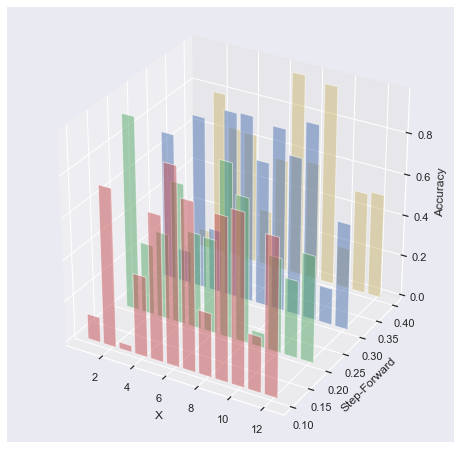

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for c, z in zip(['r', 'g', 'b', 'y'], [x[0]for x in LAMBDA][0:4]):
    xs = np.arange(1,13)
    ys = np.random.rand(12)

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Step-Forward')
ax.set_zlabel('Accuracy')

plt.show()
